# Klasifikasi Deteksi Patah Tulang (Bone Fracture) Menggunakan Deep Learning

**Deskripsi:**
Notebook ini berisi alur lengkap pengembangan model Deep Learning untuk mendeteksi patah tulang dari citra X-Ray. 
Kami membandingkan tiga arsitektur:
1. **Base CNN** (Custom Architecture)
2. **MobileNetV2** (Transfer Learning)
3. **ResNet50** (Transfer Learning)

## 1. IMPORT LIBRARY & PENYIAPAN LINGKUNGAN

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, ResNet50
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-12-25 18:50:11.442814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. KONFIGURASI DATA

In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
TRAIN_PATH = 'train'
TEST_PATH = 'val'
EPOCHS = 20

## 2. PREPROCESSING & VISUALISASI

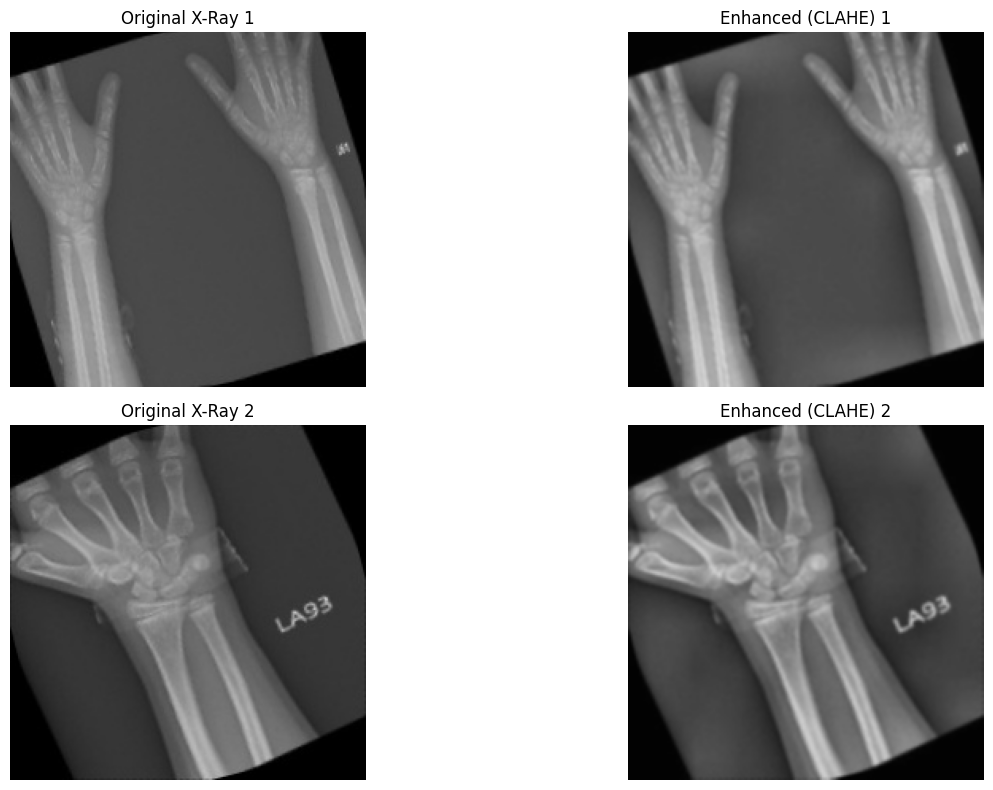

In [3]:
def medical_preprocessing(image):
    """Fungsi Preprocessing: CLAHE -> Blur -> Normalization"""
    img = np.array(image, dtype='uint8')
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # CLAHE Enhancement: Memperjelas retakan tulang
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    # Gaussian Blur: Mengurangi noise butiran pada gambar X-Ray
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
    
    # Balikkan ke RGB karena model (ResNet/MobileNet) mengharapkan 3 channel input
    final_img = cv2.cvtColor(blurred, cv2.COLOR_GRAY2RGB)
    return final_img.astype('float32') / 255.0

def show_preprocessing_examples(image_paths):
    """Menampilkan contoh perbandingan visual sebelum dan sesudah CLAHE"""
    plt.figure(figsize=(15, 8))
    for i, img_path in enumerate(image_paths):
        if not os.path.exists(img_path): continue
        original = load_img(img_path, target_size=IMG_SIZE)
        original_arr = img_to_array(original)
        processed = medical_preprocessing(original_arr)
        
        plt.subplot(len(image_paths), 2, 2*i + 1)
        plt.imshow(original_arr.astype('uint8'))
        plt.title(f"Original X-Ray {i+1}")
        plt.axis('off')
        
        plt.subplot(len(image_paths), 2, 2*i + 2)
        plt.imshow(processed)
        plt.title(f"Enhanced (CLAHE) {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_preprocessing_examples(['train/fractured/10-rotated1-rotated1-rotated1.jpg', 'train/not fractured/4-rotated2-rotated3-rotated1-rotated1.jpg'])

## 3. DATA GENERATOR

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=medical_preprocessing,
    validation_split=0.2,
    rotation_range=15,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

val_test_datagen = ImageDataGenerator(preprocessing_function=medical_preprocessing)

train_gen = train_datagen.flow_from_directory(TRAIN_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', subset='training')
val_gen = train_datagen.flow_from_directory(TRAIN_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', subset='validation', shuffle=False)
test_gen = val_test_datagen.flow_from_directory(TEST_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

Found 7091 images belonging to 2 classes.
Found 1772 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


## 4. FUNGSI EVALUASI & ANALISIS ERROR

In [5]:
final_reports = []

def evaluate_and_analyze(model, history, generator, name):
    print(f"\n[INFO] Mengevaluasi Model: {name}...")
    
    # 1. Prediksi Awal
    Y_pred = model.predict(generator, verbose=0)
    y_pred = np.where(Y_pred > 0.5, 1, 0).flatten()
    y_true = generator.classes
    
    # 2. Analisis Gambar yang Salah (Misclassified)
    errors = np.where(y_pred != y_true)[0]
    if len(errors) > 0:
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Contoh Kesalahan Klasifikasi pada Model {name}", fontsize=12)
        num_show = min(4, len(errors))
        for i in range(num_show):
            idx = errors[i]
            # Mengambil batch dan index spesifik
            batch_idx = idx // BATCH_SIZE
            img_in_batch = idx % BATCH_SIZE
            img = generator[batch_idx][0][img_in_batch]
            
            t_label = "Fractured" if y_true[idx] == 1 else "Normal"
            p_label = "Fractured" if y_pred[idx] == 1 else "Normal"
            
            plt.subplot(1, num_show, i+1)
            plt.imshow(img)
            plt.title(f"True: {t_label}\nPred: {p_label}")
            plt.axis('off')
        plt.show()
    
    # 3. Plot Learning Curves (History)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.title(f'Akurasi - {name}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'Loss - {name}')
    plt.legend()
    plt.show()

    # 4. Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Patah'], yticklabels=['Normal', 'Patah'])
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # 5. Simpan Metrik Utama ke List (HANYA SATU KALI DI SINI)
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    final_reports.append({
        'Model': name,
        'Accuracy': report_dict['accuracy'],
        'Precision': report_dict['macro avg']['precision'],
        'Recall': report_dict['macro avg']['recall'],
        'F1-Score': report_dict['macro avg']['f1-score']
    })
    
    # Tampilkan teks report singkat di console
    print(f"\nClassification Report - {name}:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Fractured']))
    print(f"✅ Evaluasi {name} selesai.")

## 5. TRAINING MODELS

### --- 1. BASE CNN ---

/mnt/d/kuliah/pembelajaran mesin/lab/bone-fracture/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1766663447.491803    6001 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1766 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/20


2025-12-25 18:50:50.551326: I external/local_xla/xla/service/service.cc:163] XLA service 0x7a4bd4004380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-25 18:50:50.551362: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-12-25 18:50:50.645529: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-25 18:50:50.980643: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


  1/222 ━━━━━━━━━━━━━━━━━━━━ 29:14 8s/step - accuracy: 0.4688 - loss: 0.6946

I0000 00:00:1766663457.282744    6877 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


222/222 ━━━━━━━━━━━━━━━━━━━━ 88s 360ms/step - accuracy: 0.5043 - loss: 0.6939 - val_accuracy: 0.4938 - val_loss: 0.6948
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 74s 332ms/step - accuracy: 0.5084 - loss: 0.6934 - val_accuracy: 0.5056 - val_loss: 0.6962
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 75s 338ms/step - accuracy: 0.5143 - loss: 0.6916 - val_accuracy: 0.2844 - val_loss: 0.7061
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 75s 335ms/step - accuracy: 0.5190 - loss: 0.6898 - val_accuracy: 0.2331 - val_loss: 0.7203
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 76s 339ms/step - accuracy: 0.5233 - loss: 0.6870 - val_accuracy: 0.3995 - val_loss: 0.7277
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 132s 594ms/step - accuracy: 0.5255 - loss: 0.6857 - val_accuracy: 0.3109 - val_loss: 0.7328
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 106s 476ms/step - accuracy: 0.5209 - loss: 0.6847 - val_accuracy: 0.2641 - val_loss: 0.7454
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 105s 472ms/step - accuracy: 0.5180 - loss: 0.6830 - 

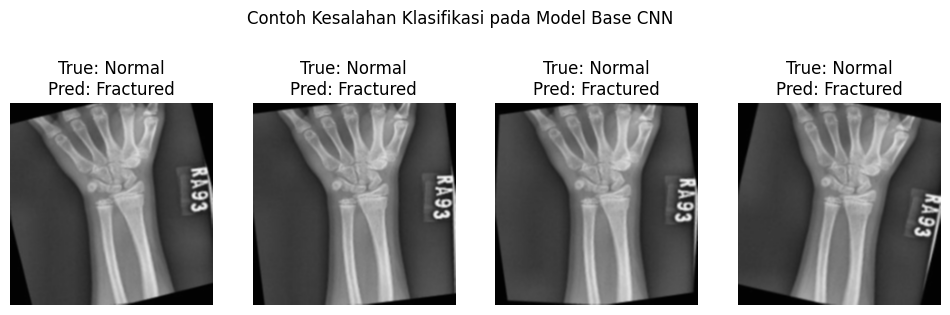

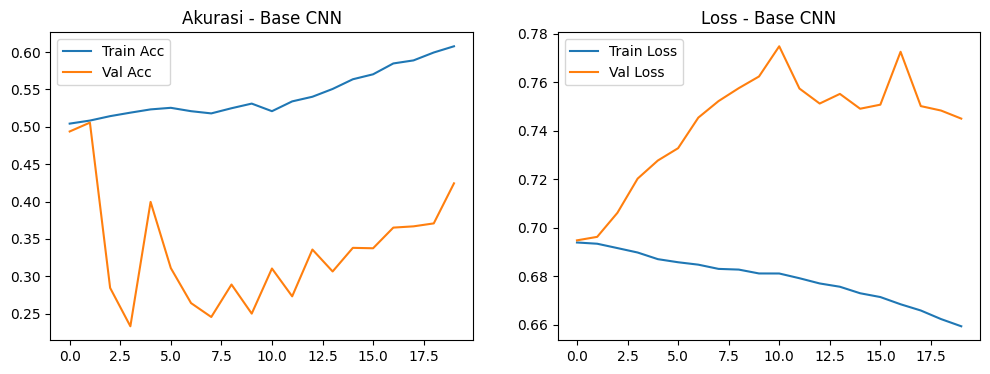

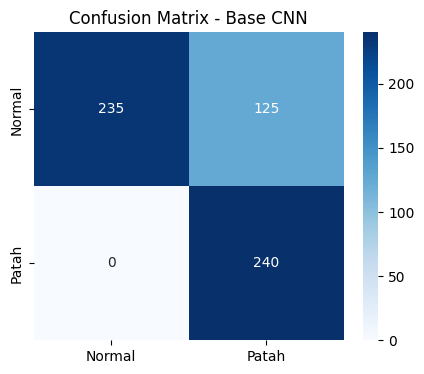


Classification Report - Base CNN:
              precision    recall  f1-score   support

      Normal       1.00      0.65      0.79       360
   Fractured       0.66      1.00      0.79       240

    accuracy                           0.79       600
   macro avg       0.83      0.83      0.79       600
weighted avg       0.86      0.79      0.79       600

✅ Evaluasi Base CNN selesai.


In [6]:
model_base = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])
model_base.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_base = model_base.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
evaluate_and_analyze(model_base, hist_base, test_gen, "Base CNN")
model_base.save('model_base_cnn.h5')

### --- 2. MOBILENET V2 (Transfer Learning 1) ---

Epoch 1/20


2025-12-25 19:24:38.633551: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 19:24:38.899370: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 19:24:39.154949: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


128/222 ━━━━━━━━━━━━━━━━━━━━ 32s 344ms/step - accuracy: 0.6272 - loss: 0.6296

136/222 ━━━━━━━━━━━━━━━━━━━━ 29s 344ms/step - accuracy: 0.6316 - loss: 0.6258

2025-12-25 19:25:39.251057: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 19:25:39.477349: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 19:25:39.701903: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.6685 - loss: 0.5918

2025-12-25 19:26:34.094755: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 19:26:34.362781: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 19:26:34.590775: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-25 19:26:34.785790: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv (f32[12,960,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,960,7,7]{3,2,1,0}, f32[960,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_

222/222 ━━━━━━━━━━━━━━━━━━━━ 141s 526ms/step - accuracy: 0.7460 - loss: 0.5164 - val_accuracy: 0.5660 - val_loss: 0.6846
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 75s 339ms/step - accuracy: 0.8529 - loss: 0.3773 - val_accuracy: 0.6168 - val_loss: 0.6786
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 77s 346ms/step - accuracy: 0.8846 - loss: 0.3212 - val_accuracy: 0.6168 - val_loss: 0.6898
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 79s 357ms/step - accuracy: 0.9058 - loss: 0.2803 - val_accuracy: 0.5988 - val_loss: 0.7177
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 80s 361ms/step - accuracy: 0.9140 - loss: 0.2595 - val_accuracy: 0.6078 - val_loss: 0.7378
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 80s 359ms/step - accuracy: 0.9319 - loss: 0.2275 - val_accuracy: 0.6055 - val_loss: 0.7791
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 123s 556ms/step - accuracy: 0.9372 - loss: 0.2144 - val_accuracy: 0.5982 - val_loss: 0.7949
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 97s 443ms/step - accuracy: 0.9378 - loss: 0.2056 - v

2025-12-25 19:52:25.243237: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv (f32[24,576,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,576,14,14]{3,2,1,0}, f32[576,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-12-25 19:52:25.651184: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.412210272s
Trying algorithm eng3{k11=2} for conv (f32[24,576,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,576,14,14]{3,2,1,0}, f32[576,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn

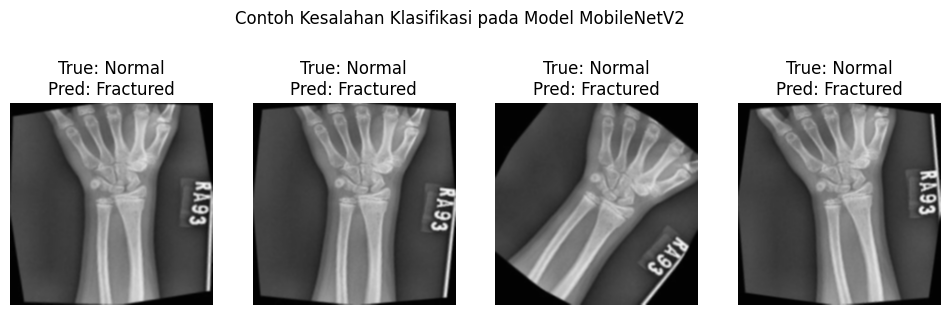

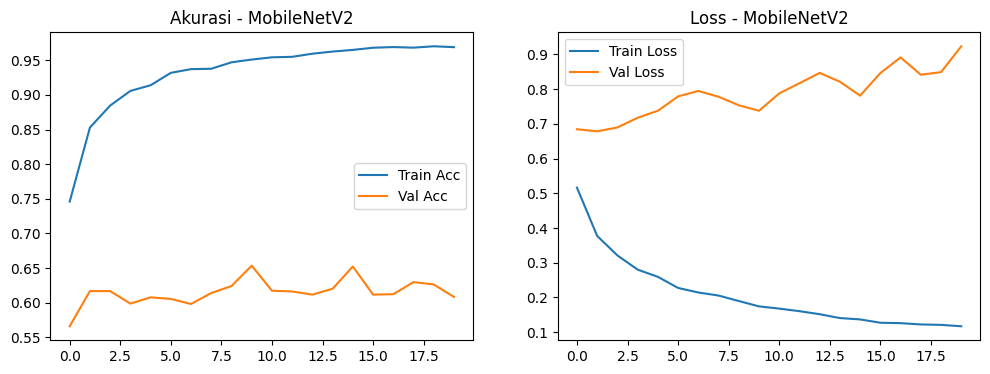

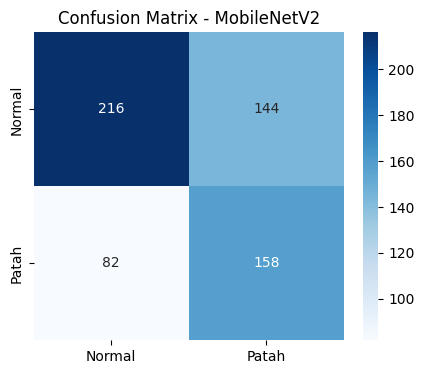


Classification Report - MobileNetV2:
              precision    recall  f1-score   support

      Normal       0.72      0.60      0.66       360
   Fractured       0.52      0.66      0.58       240

    accuracy                           0.62       600
   macro avg       0.62      0.63      0.62       600
weighted avg       0.64      0.62      0.63       600

✅ Evaluasi MobileNetV2 selesai.


In [7]:
base_mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_mobile.trainable = False
model_mobile = models.Sequential([
    base_mobile,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])
model_mobile.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_mobile = model_mobile.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
evaluate_and_analyze(model_mobile, hist_mobile, test_gen, "MobileNetV2")
model_mobile.save('model_mobilenetv2.h5')

### --- 3. RESNET50 (Transfer Learning 2) ---

Epoch 1/20


2025-12-25 19:52:43.053463: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


222/222 ━━━━━━━━━━━━━━━━━━━━ 96s 389ms/step - accuracy: 0.5090 - loss: 0.6997 - val_accuracy: 0.5056 - val_loss: 0.7112
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 75s 336ms/step - accuracy: 0.5397 - loss: 0.6851 - val_accuracy: 0.4650 - val_loss: 0.7010
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 76s 341ms/step - accuracy: 0.5726 - loss: 0.6740 - val_accuracy: 0.4735 - val_loss: 0.7110
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 77s 346ms/step - accuracy: 0.5762 - loss: 0.6701 - val_accuracy: 0.4351 - val_loss: 0.7138
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 77s 345ms/step - accuracy: 0.5844 - loss: 0.6637 - val_accuracy: 0.4283 - val_loss: 0.7131
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 75s 339ms/step - accuracy: 0.5924 - loss: 0.6593 - val_accuracy: 0.4842 - val_loss: 0.7267
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 80s 358ms/step - accuracy: 0.5965 - loss: 0.6560 - val_accuracy: 0.4199 - val_loss: 0.7162
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 78s 351ms/step - accuracy: 0.5937 - loss: 0.6535 - val

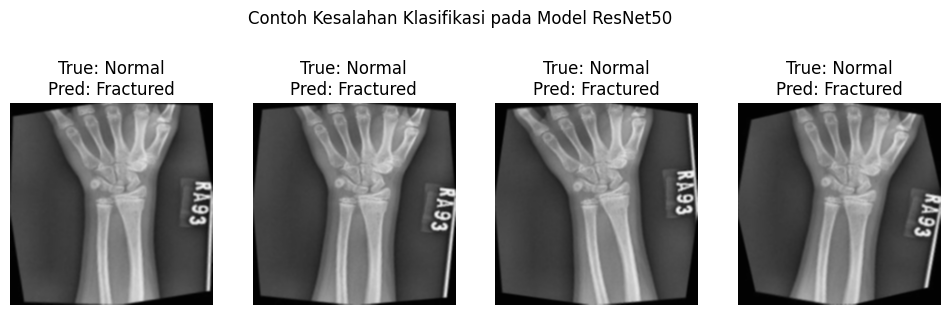

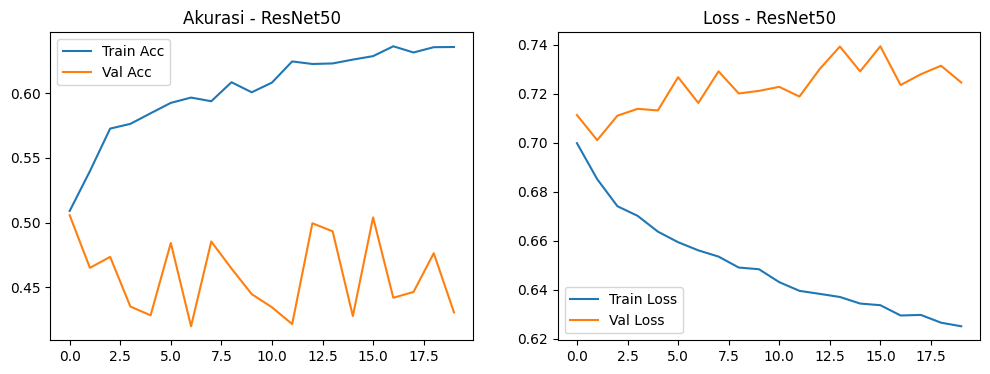

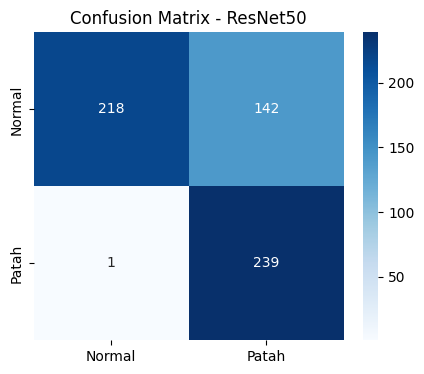


Classification Report - ResNet50:
              precision    recall  f1-score   support

      Normal       1.00      0.61      0.75       360
   Fractured       0.63      1.00      0.77       240

    accuracy                           0.76       600
   macro avg       0.81      0.80      0.76       600
weighted avg       0.85      0.76      0.76       600

✅ Evaluasi ResNet50 selesai.


In [8]:
base_res = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_res.trainable = False
model_res = models.Sequential([
    base_res,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])
model_res.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_res = model_res.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)
evaluate_and_analyze(model_res, hist_res,test_gen, "ResNet50")
model_res.save('model_resnet50.h5')

## 6. PERBANDINGAN AKHIR & GRAFIK

In [9]:
df_final = pd.DataFrame(final_reports)
print("\n" + "="*50)
print("TABEL RINGKASAN PERFORMA MODEL (CLASSIFICATION REPORT)")
print("="*50)
pd.DataFrame(final_reports)



TABEL RINGKASAN PERFORMA MODEL (CLASSIFICATION REPORT)


,Model,Accuracy,Precision,Recall,F1-Score
0,Base CNN,0.791667,0.828767,0.826389,0.791652
1,MobileNetV2,0.623333,0.624006,0.629167,0.619780
2,ResNet50,0.761667,0.811365,0.800694,0.761374


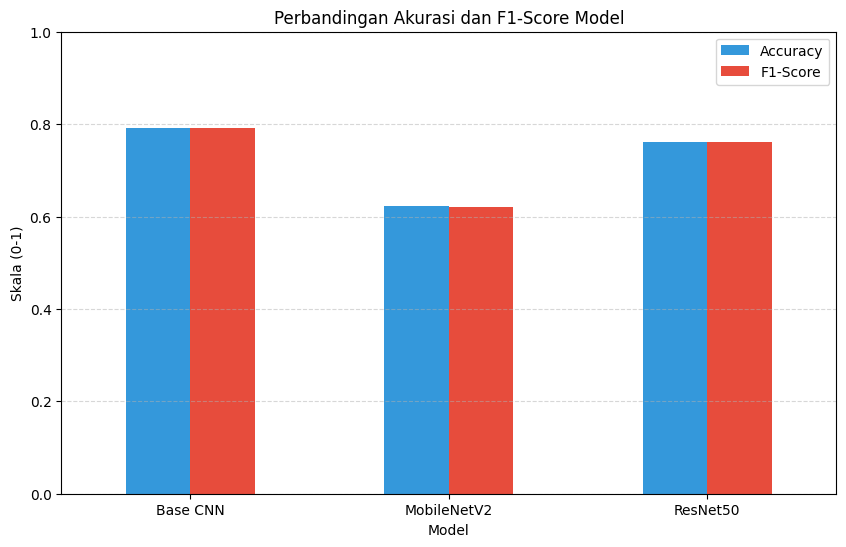

In [10]:
# Visualisasi Grafik Perbandingan
df_final.set_index('Model')[['Accuracy', 'F1-Score']].plot(kind='bar', figsize=(10, 6), color=['#3498db', '#e74c3c'])
plt.title("Perbandingan Akurasi dan F1-Score Model")
plt.ylabel("Skala (0-1)")
plt.ylim(0, 1.0)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()